# Comparison (on my way), the executing time

## Libraries

In [2]:
import gym
import time
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Making the environment

In [3]:
env = gym.make('FrozenLake-v1', render_mode='', is_slippery=True, map_name='8x8')
# env.reset()
# env.render()
# env.close()
runs = np.array([0, 2000, 4000, 6000, 8000, 10000])

C:\Users\saath\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\gym\envs\registration.py:623: UserWarning: WARN: The environment is being initialised with mode () that is not in the possible render_modes (['human', 'ansi', 'rgb_array']).
  logger.warn(


### Exploring a little bit Policy Evaluation

In [4]:
'''Policy Evaluation'''
gamma = 0.9
numberIterations = 10000
tolerance = 10**-6
valueFunctionVector = np.zeros(env.observation_space.n)
# Lista para seguir la convergenci
convergenceTrack = []

rewardCumulativePolicyEvaluation = np.zeros(numberIterations)
q=0

for iterations in range(numberIterations):
    # Registra la norma 2 del vector de funciones de valor en esta iteración
    convergenceTrack.append(np.linalg.norm(valueFunctionVector, 2))
    valueFunctionVectorNextIteration = np.zeros(env.observation_space.n)
    for states in env.P:
        outerSum = 0
        for actions in env.P[states]:
            innerSum = 0
            for probability, nextState, reward, isTerminalState in env.P[states][actions]:
                innerSum = innerSum + probability * (reward + gamma*valueFunctionVector[nextState])
                '''Cumulative Reward'''
                if reward == 1:
                    rewardCumulativePolicyEvaluation[iterations] = 1 + rewardCumulativePolicyEvaluation[iterations-1]
                    print(f'iteration: {iterations}, reward: {reward}')
            outerSum = outerSum + 0.25*innerSum
            # print(f'iteration: {iterations}, reward: {reward}')
            q += 1
        valueFunctionVectorNextIteration[states] = outerSum
        # print(f'iteration: {iterations}, reward: {reward}')

    # print(q)
    if reward == 1:
        rewardCumulativePolicyEvaluation[iterations] = 1 + rewardCumulativePolicyEvaluation[iterations-1]
        
    if(np.max(np.abs(valueFunctionVector - valueFunctionVectorNextIteration))<tolerance):
        valueFunctionVector = valueFunctionVectorNextIteration
        # print('Converged!')
        # break
    valueFunctionVector = valueFunctionVectorNextIteration

iteration: 0, reward: 1.0
iteration: 0, reward: 1.0
iteration: 0, reward: 1.0
iteration: 0, reward: 1.0
iteration: 0, reward: 1.0
iteration: 0, reward: 1.0
iteration: 1, reward: 1.0
iteration: 1, reward: 1.0
iteration: 1, reward: 1.0
iteration: 1, reward: 1.0
iteration: 1, reward: 1.0
iteration: 1, reward: 1.0
iteration: 2, reward: 1.0
iteration: 2, reward: 1.0
iteration: 2, reward: 1.0
iteration: 2, reward: 1.0
iteration: 2, reward: 1.0
iteration: 2, reward: 1.0
iteration: 3, reward: 1.0
iteration: 3, reward: 1.0
iteration: 3, reward: 1.0
iteration: 3, reward: 1.0
iteration: 3, reward: 1.0
iteration: 3, reward: 1.0
iteration: 4, reward: 1.0
iteration: 4, reward: 1.0
iteration: 4, reward: 1.0
iteration: 4, reward: 1.0
iteration: 4, reward: 1.0
iteration: 4, reward: 1.0
iteration: 5, reward: 1.0
iteration: 5, reward: 1.0
iteration: 5, reward: 1.0
iteration: 5, reward: 1.0
iteration: 5, reward: 1.0
iteration: 5, reward: 1.0
iteration: 6, reward: 1.0
iteration: 6, reward: 1.0
iteration: 6

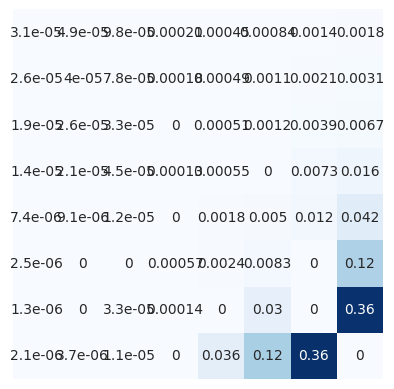

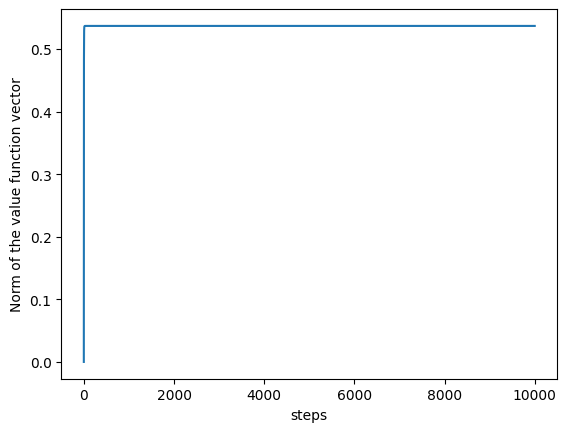

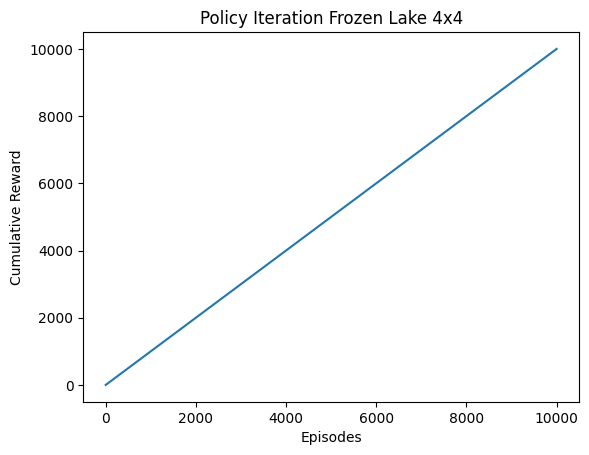

In [5]:
# visualize the state values
def grid_print(valueFunction,reshapeDim):
    ax = sns.heatmap(valueFunctionVector.reshape(8,8),
                     annot=True, square=True,
                     cbar=False, cmap='Blues',
                     xticklabels=False, yticklabels=False)
    plt.savefig('PolicyEvaluationGridSlippery=True.png',dpi=600)
    plt.show()
     
grid_print(valueFunctionVector,4)
 
plt.plot(convergenceTrack)
plt.xlabel('steps')
plt.ylabel('Norm of the value function vector')
plt.savefig('policyEvaluationCONVERGENCE_Slippery=false.png',dpi=600)
plt.show()
plt.plot(rewardCumulativePolicyEvaluation)
plt.title('Policy Iteration Frozen Lake 4x4')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Reward')
plt.show()

## Policy-Iteration

In [6]:
def evaluatePolicy(env,valueFunctionVector,policy,discountRate,maxNumberOfIterations,convergenceTolerance):
    convergenceTrack=[]
    for iterations in range(maxNumberOfIterations):
        convergenceTrack.append(np.linalg.norm(valueFunctionVector,2))
        valueFunctionVectorNextIteration=np.zeros(env.observation_space.n)
        for state in env.P:
            outerSum=0
            for action in env.P[state]:
                innerSum=0
                for probability, nextState, reward, isTerminalState in env.P[state][action]:
                    #print(probability, nextState, reward, isTerminalState)
                    innerSum=innerSum+ probability*(reward+discountRate*valueFunctionVector[nextState])
                outerSum=outerSum+policy[state,action]*innerSum
            valueFunctionVectorNextIteration[state]=outerSum
        if(np.max(np.abs(valueFunctionVectorNextIteration-valueFunctionVector))<convergenceTolerance):
            valueFunctionVector=valueFunctionVectorNextIteration
            print('Iterative policy evaluation algorithm converged!')
            break
        valueFunctionVector=valueFunctionVectorNextIteration       
    return valueFunctionVector

In [7]:
def improvePolicy(env,valueFunctionVector,numberActions,numberStates,discountRate):
    # this matrix will store the q-values (action value functions) for every state
    # this matrix is returned by the function 
    qvaluesMatrix=np.zeros((numberStates,numberActions))
    # this is the improved policy
    # this matrix is returned by the function
    improvedPolicy=np.zeros((numberStates,numberActions))
     
    for stateIndex in range(numberStates):
        # computes a row of the qvaluesMatrix[stateIndex,:] for fixed stateIndex, 
        # this loop iterates over the actions
        for actionIndex in range(numberActions):
            # computes the Bellman equation for the action value function
            for probability, nextState, reward, isTerminalState in env.P[stateIndex][actionIndex]:
                qvaluesMatrix[stateIndex,actionIndex]=qvaluesMatrix[stateIndex,actionIndex]+probability*(reward+discountRate*valueFunctionVector[nextState])
             
        # find the action indices that produce the highest values of action value functions
        bestActionIndex=np.where(qvaluesMatrix[stateIndex,:]==np.max(qvaluesMatrix[stateIndex,:]))
 
        # form the improved policy        
        improvedPolicy[stateIndex,bestActionIndex]=1/np.size(bestActionIndex)
    return improvedPolicy,qvaluesMatrix

In [8]:
# env=gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False,render_mode="")
 
##########################################################################
#           general parameters for the policy iteration
##########################################################################
discountRate=0.9
# number of states - determined by the Frozen Lake environment
stateNumber=64
# number of possible actions in every state - determined by the Frozen Lake environment
actionNumber=4
# maximal number of iterations of the policy iteration algorithm 
maxNumberOfIterationsOfPolicyIteration= 600
 
# select an initial policy
# initial policy starts with a completely random policy
# that is, in every state, there is an equal probability of choosing a particular action
initialPolicy=(1/actionNumber)*np.ones((stateNumber,actionNumber))
##########################################################################
#           parameters of the iterative policy evaluation algorithm
##########################################################################
# initialize the value function vector
valueFunctionVectorInitial=np.zeros(env.observation_space.n)
# maximum number of iterations of the iterative policy evaluation algorithm
# convergence tolerance 
convergenceToleranceIterativePolicyEvaluation=10**(-6)

# maximum number of iterations of the iterative policy evaluation algorithm
maxNumberOfIterationsOfIterativePolicyEvaluation=10000

for iteration in range(maxNumberOfIterationsOfPolicyIteration):
    # print("Iteration - {} - of policy iteration algorithm".format(iteration))
    if (iteration == 0):
        currentPolicy=initialPolicy
    valueFunctionVectorComputed =evaluatePolicy(env,valueFunctionVectorInitial,currentPolicy,discountRate,maxNumberOfIterationsOfIterativePolicyEvaluation,convergenceToleranceIterativePolicyEvaluation)
    improvedPolicy,qvaluesMatrix=improvePolicy(env,valueFunctionVectorComputed,actionNumber,stateNumber,discountRate)
    # if two policies are equal up to a certain "small" tolerance
    # then break the loop - our algorithm converged
    if np.allclose(currentPolicy,improvedPolicy):
        currentPolicy=improvedPolicy
        # print("Policy iteration algorithm converged!")
        break
    currentPolicy=improvedPolicy

Iterative policy evaluation algorithm converged!
Iterative policy evaluation algorithm converged!
Iterative policy evaluation algorithm converged!
Iterative policy evaluation algorithm converged!


In [9]:
'''Executed time'''
# time_takenValueIteration[0] = 0 # 0 iterations
# time_takenValueIteration[1] = 5.1 # 2000 iterations
# time_takenValueIteration[2] = 10 # 4000 iterationsq
# time_takenValueIteration[3] = 12.4 # 6000 iterations
# time_takenValueIteration[4] = 16.7 # 8000 iterations
# time_takenValueIteration[5] = 20.6 # 10000 iterations
time_takenPolicyIteration = np.array([0, 5.1, 10, 12.4, 16.7, 20.6])
# plt.plot(runs, time_takenPolicyIteration)
# plt.plot(runs, time_takenValueIteration)
# plt.title('Time taken for Value Iteration')
# plt.xlabel('Iterations')
# plt.ylabel('Time (s)')

In [10]:
# sns.heatmap(qvaluesMatrix,annot=True,fmt=".1f",cmap='Blues')
# plt.title('Action Value Functions')
# plt.xlabel('Actions')
# plt.ylabel('States')

In [11]:
# sns.heatmap(valueFunctionVectorComputed.reshape(4,4),annot=True,fmt=".2f",cmap='Blues')
# plt.title('State Value Function')
# # plt.xlabel('Columns')
# # plt.ylabel('Rows')

In [12]:
# sns.heatmap(currentPolicy, annot=True, fmt=".2f", cmap='Blues', cbar=False)
# plt.title('Final Policy')
# plt.xlabel('Actions')
# plt.ylabel('States')

## Value-Iteration

In [13]:
'''ValueIteration'''
# Selecciona el factor de descuento
discountFactor = 0.9
# Inicializa el vector de la función de valor
valueFunctionVector = np.zeros(env.observation_space.n)
# Número máximo de iteraciones
maxNumberOfIterations = 10000
# Tolerancia para la convergencia
convergenceTolerance = 10**(-6)

# Lista para seguir la convergencia
convergenceTrack = []
cumulativeRewardValueIteration = np.zeros(maxNumberOfIterations)

for iterations in range(maxNumberOfIterations):
    # Registra la norma 2 del vector de funciones de valor en esta iteración
    convergenceTrack.append(np.linalg.norm(valueFunctionVector, 2))
    # start_time = time.time( )
    # Inicializa el vector de la función de valor para la próxima iteración
    valueFunctionVectorNextIteration = np.zeros(env.observation_space.n)
    
    for state in env.P:
        maxValue = -np.inf
        for action in env.P[state]:
            innerSum = 0
            for probability, nextState, reward, isTerminalState in env.P[state][action]:
                innerSum += probability * (reward + discountFactor * valueFunctionVector[nextState])

                if reward == 1:
                    cumulativeRewardValueIteration[iterations] = 1 + cumulativeRewardValueIteration[iterations-1]

            # Tomamos el máximo valor entre las acciones disponibles
            if innerSum > maxValue:
                maxValue = innerSum
        valueFunctionVectorNextIteration[state] = maxValue
        if reward == 1:
            cumulativeRewardValueIteration[iterations] = 1 + cumulativeRewardValueIteration[iterations-1]

    '''Cumulative Reward'''
    if reward == 1:
        cumulativeRewardValueIteration[iterations] = 1 + cumulativeRewardValueIteration[iterations-1]
    
    # Comprueba si la diferencia máxima entre iteraciones es menor que la tolerancia
    if np.max(np.abs(valueFunctionVectorNextIteration - valueFunctionVector)) < convergenceTolerance:
        valueFunctionVector = valueFunctionVectorNextIteration
        # print('Converged!')
        # break
    
    # Actualiza el vector de funciones de valor
    valueFunctionVector = valueFunctionVectorNextIteration

    # time_taken = time.time() - start_time
    # time_takenValueIteration.append(time_taken)

# Si se desea, se puede imprimir el vector de valores al final
print('Value Function:', valueFunctionVector)

Value Function: [0.00641111 0.00854815 0.0123005  0.01778948 0.02508218 0.03247093
 0.03957138 0.04297848 0.00602413 0.00764519 0.01091169 0.0164266
 0.02605416 0.03619413 0.04935474 0.05730465 0.00509032 0.00585328
 0.00677541 0.         0.02557088 0.03882143 0.06763977 0.0843561
 0.00422568 0.00476961 0.00581975 0.00785413 0.02036068 0.
 0.09175505 0.12919114 0.00318101 0.00319666 0.00270492 0.
 0.03444393 0.06195147 0.10901924 0.20969095 0.00186925 0.
 0.         0.0108508  0.03250094 0.06304174 0.         0.36008775
 0.00118058 0.         0.00137719 0.0036684  0.         0.11568672
 0.         0.6305138  0.00088543 0.00077472 0.00092225 0.
 0.13824885 0.32258065 0.61443932 0.        ]


In [14]:
'''Executed time'''
# time_takenValueIteration[0] = 0 # 0 iterations
# time_takenValueIteration[1] = 0.4 # 2000 iterations
# time_takenValueIteration[2] = 0.7 # 4000 iterationsq
# time_takenValueIteration[3] = 1 # 6000 iterations
# time_takenValueIteration[4] = 1.6 # 8000 iterations
# time_takenValueIteration[5] = 2 # 10000 iterations
time_takenValueIteration = np.array([0, 0.4, 0.7, 1, 1.6, 2])
# plt.plot(runs, time_takenValueIteration)
# plt.title('Time taken for Value Iteration')
# plt.xlabel('Iterations')
# plt.ylabel('Time (s)')

In [15]:
# plt.plot(cumulativeRewardValueIteration)
# plt.title('Value Iteration Frozen Lake 4x4')
# plt.xlabel('Episodes')
# plt.ylabel('Cumulative Rewards')
# # plt.xlim(0,50000)

In [16]:
# # visualize the state values
# def grid_print(valueFunction,reshapeDim):
#     ax = sns.heatmap(valueFunction.reshape(4,4),
#                      annot=True, square=True,
#                      cbar=False, cmap='Blues',
#                      xticklabels=False, yticklabels=False)
#     plt.savefig('valueFunctionGridSlippery=True.png',dpi=600)
#     plt.show()
     
# sns.heatmap(valueFunctionVector.reshape(4,4), annot=True, square=True, cbar=False, cmap='Blues')
# # sns.heatmap(qvaluesMatrix,annot=True,fmt=".1f",cmap='Blues')

# # grid_print(valueFunctionVector,4)
# # plt.plot(convergenceTrack)
# plt.title('Frozen Lake Value Function Convergence')
# # plt.xlabel('steps')
# # plt.ylabel('Norm of the value function vector')
# # plt.savefig('valueFunctionCONVERGENCE_Slippery=True.png',dpi=600)
# # plt.show()

## Q-Learning

C:\Users\saath\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


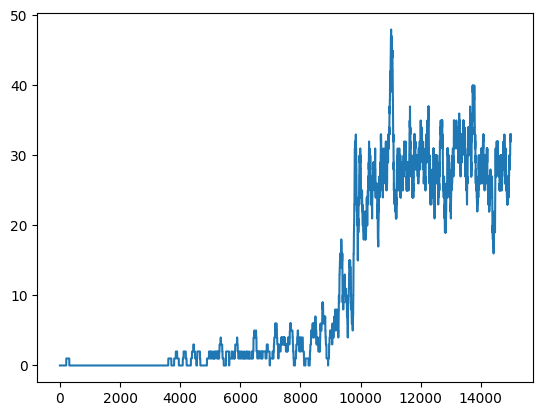

In [17]:
def run(episodes, is_training=True, render=False):

    env = gym.make('FrozenLake-v1', map_name="8x8", is_slippery=True, render_mode='' if render else None)

    if(is_training):
        q = np.zeros((env.observation_space.n, env.action_space.n)) # init a 64 x 4 array
        # print(env.observation_space.n, env.action_space.n)
    else:
        f = open('frozen_lake4x4.pkl', 'rb')
        q = pickle.load(f)
        f.close()

    learning_rate_a = 0.9 # alpha or learning rate
    discount_factor_g = 0.9 # gamma or discount rate. Near 0: more weight/reward placed on immediate state. Near 1: more on future state.
    epsilon = 1         # 1 = 100% random actions
    epsilon_decay_rate = 0.0001        # epsilon decay rate. 1/0.0001 = 10,000
    rng = np.random.default_rng()   # random number generator

    rewards_per_episode = np.zeros(episodes)
    accumulative_reward = []

    for i in range(episodes):
        state = env.reset()[0]  # states: 0 to 63, 0=top left corner,63=bottom right corner
        terminated = False      # True when fall in hole or reached goal
        truncated = False       # True when actions > 200

        while(not terminated and not truncated):
            if is_training and rng.random() < epsilon:
                action = env.action_space.sample() # actions: 0=left,1=down,2=right,3=up
            else:
                action = np.argmax(q[state,:])

            new_state,reward,terminated,truncated,_ = env.step(action)

            if is_training:
                q[state,action] = q[state,action] + learning_rate_a * (
                    reward + discount_factor_g * np.max(q[new_state,:]) - q[state,action]
                )
            if reward == 1:
                rewards_per_episode[i] = 1 + rewards_per_episode[i-1]

            state = new_state

        epsilon = max(epsilon - epsilon_decay_rate, 0)

        if(epsilon==0):
            learning_rate_a = 0.0001

        if reward == 1:
            rewards_per_episode[i] = 1


    env.close()

    sum_rewards = np.zeros(episodes)
    for t in range(episodes):
        sum_rewards[t] = np.sum(rewards_per_episode[max(0, t-100):(t+1)])
    plt.plot(sum_rewards)
    plt.show()
    # plt.savefig('frozen_lake4x4.png')

    # plt.plot(accumulative_reward)
    # plt.show()

    if is_training:
        f = open("frozen_lake8x8.pkl","wb")
        pickle.dump(q, f)
        f.close()

if __name__ == '__main__':
    # run(15000)

    run(15000, is_training=True, render=False)

In [18]:
# '''Executed time -  Another scale'''
# # time_takenValueIteration[0] = 0 # 0 iterations
# # time_takenValueIteration[1] = 0.1 # 200 iterations
# # time_takenValueIteration[2] = 0.2 # 4000 iterationsq
# # time_takenValueIteration[3] = 1.4 # 6000 iterations
# # time_takenValueIteration[4] = 1.8 # 8000 iterations
# # time_takenValueIteration[5] = 2.1 # 10000 iterations
# time_takenQLearning = np.array([0, 0.6, 0.9, 1.4, 1.8, 2.1])
# runs = np.array([0, 2000, 4000, 6000, 8000, 10000])
# plt.plot(runs, time_takenValueIteration)
# plt.title('Time taken for Q-Learning')
# plt.xlabel('Iterations')
# plt.ylabel('Time (s)')

In [19]:
'''Executed time'''
# time_takenValueIteration[0] = 0 # 0 iterations
# time_takenValueIteration[1] = 0.6 # 2000 iterations
# time_takenValueIteration[2] = 0.9 # 4000 iterationsq
# time_takenValueIteration[3] = 1.4 # 6000 iterations
# time_takenValueIteration[4] = 1.8 # 8000 iterations
# time_takenValueIteration[5] = 2.1 # 10000 iterations
time_takenQLearning = np.array([0, 0.6, 0.9, 1.4, 1.8, 2.1])
# plt.plot(runs, time_takenValueIteration)
# plt.title('Time taken for Q-Learning')
# plt.xlabel('Iterations')
# plt.ylabel('Time (s)')

In [20]:
# Register the enhanced frozen lake environment
# Sample of registration entry found in C:\Users\<username>\.conda\envs\gymenv\Lib\site-packages\gymnasium\envs\__init__.py
gym.register(
    id="FrozenLake-enhanced", # give it a unique id
    entry_point="frozen_lake_enhanced:FrozenLakeEnv", # frozen_lake_enhanced = name of file 'frozen_lake_enhanced.py'
    kwargs={"map_name": "4x4"},
    max_episode_steps=200,
    reward_threshold=0.85,  # optimum = 0.91
)

## Comparison between Methods

In [21]:
'''Cumulative Reward for the three algorithms'''
# Execution incorporate along the code 

'Cumulative Reward for the three algorithms'

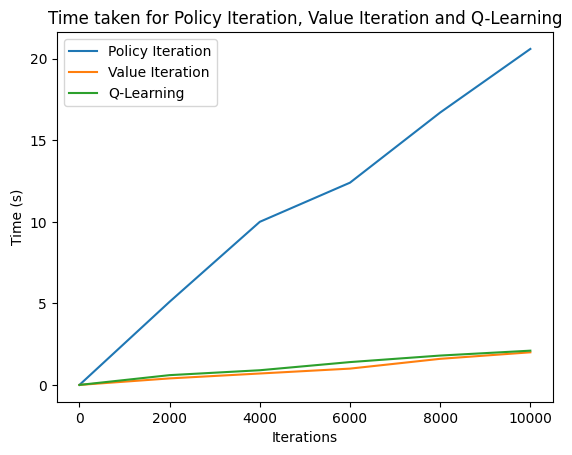

In [22]:
'''Time execution for the three algorithms'''

plt.plot(runs, time_takenPolicyIteration)
plt.plot(runs, time_takenValueIteration)
plt.plot(runs, time_takenQLearning)
plt.legend(['Policy Iteration', 'Value Iteration', 'Q-Learning'])
plt.title('Time taken for Policy Iteration, Value Iteration and Q-Learning')
plt.xlabel('Iterations')
plt.ylabel('Time (s)')
plt.show()

# References
* Rechard S. Sutton and Andrew G. Barto. Reinforcement Learning : An Introduction, second edition. The MIT Press, Cambridge, Massachusetts, London, England, 2018, 2020.
* https://gymnasium.farama.org/environments/toy_text/frozen_lake/#frozen-lake
* https://karan-jakhar.medium.com/100-days-of-code-day-1-35afe174000e
* https://medium.com/swlh/frozen-lake-as-a-markov-decision-process-1692815ecfd1